In [1]:
import numpy as np

import astropy.units as u
import astropy.time as time
import astropy.coordinates as coord

import matplotlib.pyplot as plt

from affine_fitter import AffineTransformFitter
import affine_utils as afu

np.random.seed(0)
%matplotlib inline

# Gnomonic projection definition

https://mathworld.wolfram.com/GnomonicProjection.html

In [2]:
def theta_def(b, l, b0, l0):
    '''
    For a given :math:`(b,\\ell)` angle, finds the corresponding :math:`\\vec{\\theta}` angle 
    as measured according to a reference :math:`(b_0,\\ell_0)`
    '''
    den = np.sin(b0) * np.sin(b) + np.cos(b0) * np.cos(b) * np.cos(l - l0)
    theta_x = np.cos(b) * np.sin(l - l0)/den
    theta_y = (np.cos(b0) * np.sin(b) - np.sin(b0) * np.cos(b) * np.cos(l - l0))/den
    return np.array([theta_x, theta_y])

def theta_to_b_l(theta, b0, l0):
    '''
    For a given :math:`\\boldsymbol{\\theta}`, returns the correspondent :math:`(b,\\ell)` coordinates
    '''
    den = np.sqrt(1 + theta[0]**2 + theta[1]**2)
    sin_b = (np.sin(b0) + theta[1]*np.cos(b0))/den
    sin_l = theta[0]/(np.cos(b0) * den)
    return np.arcsin(sin_b), np.arcsin(sin_l) + l0

# TNO and BBOX setup

In [3]:
# TNO and bounding box parameters
box_size = 0.5*u.degree
tno_lon = 30*u.degree
tno_lat = 30*u.degree
tno_d = 30*u.au

In [4]:
# Imagined TNO in heliocentric coordinates
tno_hel = coord.HeliocentricTrueEcliptic(lon=tno_lon, lat=tno_lat, distance=tno_d)

# Imagined timestamp of the observation isot format = YYYY-MM-DDTHH:MM:SS. sss
obs_time1 = time.Time("2022-01-01T00:00:00", format="isot", scale="utc")

In [5]:
bbox_helio = afu.make_heliocentric_bbox(
    tno_hel,
    box_size,
    n_samples=100
)

geo_eclip1 = coord.GeocentricTrueEcliptic(obstime=obs_time1)
bbox_t = bbox_helio.transform_to(geo_eclip1)

geo_eclip2 = coord.GeocentricTrueEcliptic(obstime=obs_time1 + 180*u.day)
bbox_t180 = bbox_helio.transform_to(geo_eclip2)

Calculating the central coordinates between the two bounding boxes to use as the central point of the projection.

In [6]:
bboxt_lon_mean = np.mean(bbox_t.lon.radian)
bboxt_lat_mean = np.mean(bbox_t.lat.radian)

bboxt180_lon_mean = np.mean(bbox_t180.lon.radian)
bboxt180_lat_mean = np.mean(bbox_t180.lat.radian)

lon_mean = np.mean([bboxt_lon_mean, bboxt180_lon_mean])
lat_mean = np.mean([bboxt_lat_mean, bboxt180_lat_mean])

print(lon_mean, lat_mean)

0.5232091295909832 0.5229910849838442


# Reproject bboxes

In [7]:
x, y = theta_def(bbox_t.lon.radian, bbox_t.lat.radian, lon_mean, lat_mean)

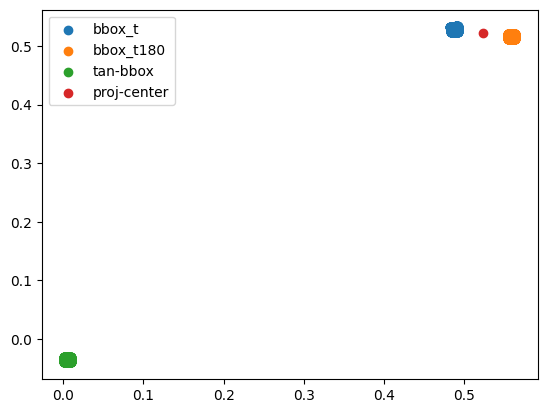

In [8]:
plt.scatter(bbox_t.lon.radian, bbox_t.lat.radian, label="bbox_t")
plt.scatter(bbox_t180.lon.radian, bbox_t180.lat.radian, label="bbox_t180")
plt.scatter(x, y, label="tan-bbox")
plt.scatter(lon_mean, lat_mean, label="proj-center")
plt.legend()

In [9]:
lon, lat = theta_to_b_l((x,y), lon_mean, lat_mean)
np.max(bbox_t.lon.radian - lon)

1.6653345369377348e-16

Ok, this is a bit strange... The projected bbox ends up very far from the projection center, but when converted back to geocentric ecliptic it reproduces the starting coordinates. I guess that just means I am using the functions consistenly, but could still be missunderstanding what the projection central coordinates are supposed to represent.

So what is the central coordinate that reprojects the center as the pole/antipodal point (i.e. performs as an identity)

In [10]:
theta_def(bboxt_lon_mean, bboxt_lat_mean, bboxt_lon_mean, bboxt_lat_mean)

array([0., 0.])

Ah, I see. The new projection center is $(0,0)$ so it's offset from the ecliptic coord system's $(0, 0)$

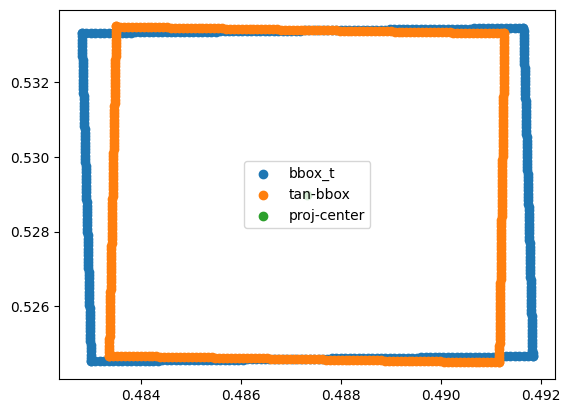

In [11]:
x, y = theta_def(bbox_t.lon.radian, bbox_t.lat.radian, bboxt_lon_mean, bboxt_lat_mean)
x += bboxt_lon_mean
y += bboxt_lat_mean
plt.scatter(bbox_t.lon.radian, bbox_t.lat.radian, label="bbox_t")
plt.scatter(x, y, label="tan-bbox")
plt.scatter(bboxt_lon_mean, bboxt_lat_mean, label="proj-center")
plt.legend()

How can I tell if this is an appropriate ammount of distorsion?

(array([41., 39., 40., 39., 41., 41., 39., 40., 39., 41.]),
 array([-8.84510685e-03, -7.07693616e-03, -5.30876547e-03, -3.54059478e-03,
        -1.77242409e-03, -4.25339913e-06,  1.76391729e-03,  3.53208798e-03,
         5.30025867e-03,  7.06842936e-03,  8.83660005e-03]),
 <BarContainer object of 10 artists>)

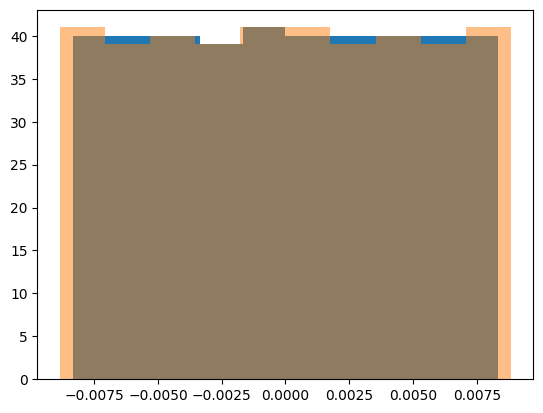

In [12]:
plt.hist(bbox_t.lon.radian-x, label="delta lon (rad)")
plt.hist(bbox_t.lat.radian-y, alpha=0.5, label="delta lat (rad)")

In [13]:
print("Maximal pointwise difference between ecliptic bbox and projected bbox longitude: "
      f"{np.max(bbox_t.lon.radian-x)*u.rad.to(u.arcsecond)} arcseconds")

Maximal pointwise difference between ecliptic bbox and projected bbox longitude: 1717.6695917344077 arcseconds


This seems a little bit much, to make sure this isn't a problem with me assuming I can just difference them.

(array([50., 40., 40., 36., 40., 38., 39., 37., 40., 40.]),
 array([0.00033864, 0.00144493, 0.00255123, 0.00365752, 0.00476381,
        0.0058701 , 0.00697639, 0.00808268, 0.00918897, 0.01029526,
        0.01140155]),
 <BarContainer object of 10 artists>)

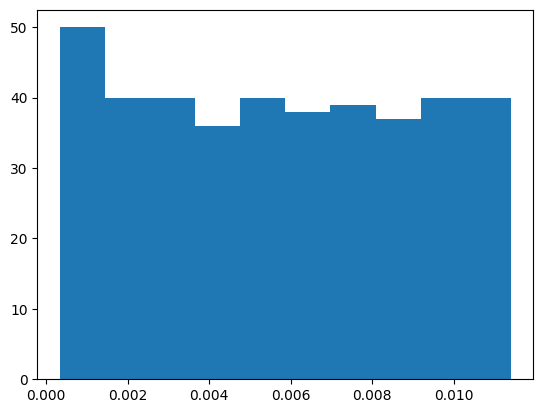

In [14]:
distances = coord.angular_separation(
        bbox_t.lon.radian,
        bbox_t.lat.radian,
        x,
        y
    )
plt.hist(distances)

In [15]:
print("Maximal pointwise difference between ecliptic bbox and projected bbox longitude: "
      f"{np.max(distances)*u.rad.to(u.arcsec)} arcseconds")

Maximal pointwise difference between ecliptic bbox and projected bbox longitude: 2351.7376662814568 arcseconds


This seems like a lot, maybe I'm doing something wrong? Maybe the lat and lon are marked differently in his code than I assumed?

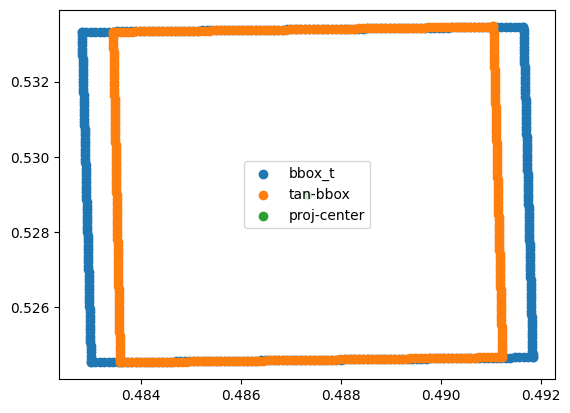

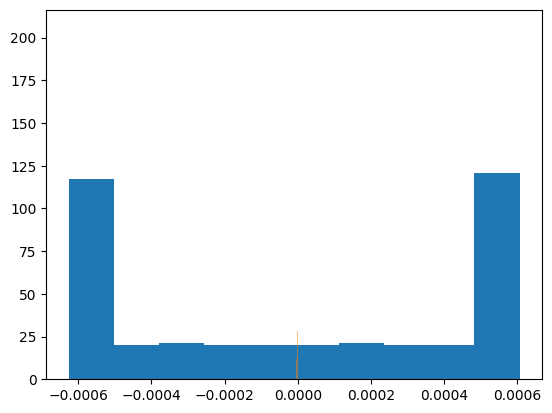

Maximal pointwise difference between ecliptic bbox and projected bbox longitude: 125.0344281961895 arcsec


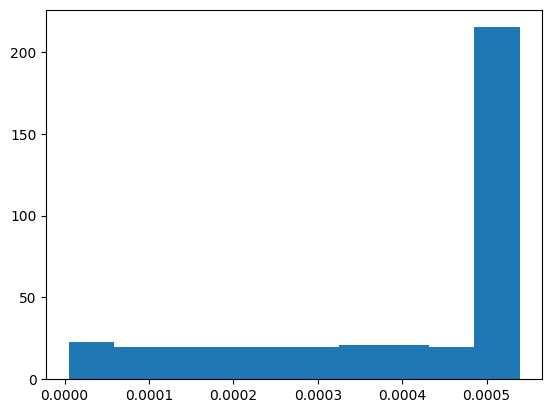

Maximal pointwise difference between ecliptic bbox and projected bbox longitude: 111.18460492786659 arcsec


In [16]:
x, y = theta_def(bbox_t.lat.radian, bbox_t.lon.radian, bboxt_lat_mean, bboxt_lon_mean)
x += bboxt_lon_mean
y += bboxt_lat_mean
plt.scatter(bbox_t.lon.radian, bbox_t.lat.radian, label="bbox_t")
plt.scatter(x, y, label="tan-bbox")
plt.scatter(bboxt_lon_mean, bboxt_lat_mean, label="proj-center")
plt.legend()
plt.show()

plt.hist(bbox_t.lon.radian-x, label="delta lon (rad)")
plt.hist(bbox_t.lat.radian-y, alpha=0.5, label="delta lat (rad)")
plt.show()
print("Maximal pointwise difference between ecliptic bbox and projected bbox longitude: "
      f"{np.max(bbox_t.lon.radian-x)*u.rad.to(u.arcsecond)} arcsec")

distances = coord.angular_separation(
        bbox_t.lon.radian,
        bbox_t.lat.radian,
        x,
        y
    )
plt.hist(distances)
plt.show()
print("Maximal pointwise difference between ecliptic bbox and projected bbox longitude: "
      f"{np.max(distances)*u.rad.to(u.arcsecond)} arcsec")

# Try the two boxes again

That seems a lot still, but let's see if I understand by plotting the two boxes again, offset so they line up.

In [23]:
bboxt_x, bboxt_y = theta_def(bbox_t.lat.radian, bbox_t.lon.radian, lat_mean, lon_mean)
bboxt_x += lon_mean
bboxt_y += lat_mean

bboxt180_x, bboxt180_y = theta_def(bbox_t180.lat.radian, bbox_t180.lon.radian, lat_mean, lon_mean)
bboxt180_x += lon_mean
bboxt180_y += lat_mean

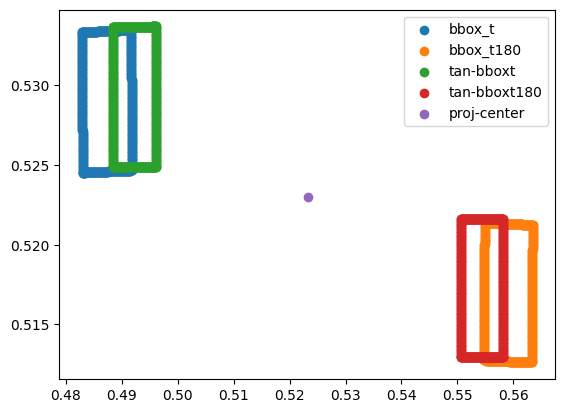

In [25]:
fig, ax = plt.subplots(figsize=())
ax.scatter(bbox_t.lon.radian, bbox_t.lat.radian, label="bbox_t")
ax.scatter(bbox_t180.lon.radian, bbox_t180.lat.radian, label="bbox_t180")
ax.scatter(bboxt_x, bboxt_y, label="tan-bboxt")
ax.scatter(bboxt180_x, bboxt180_y, label="tan-bboxt180")
ax.scatter(lon_mean, lat_mean, label="proj-center")
ax.legend()